In [87]:
import numpy as np
import pandas as pd
from keras.models import Sequential, Model

In [88]:
from keras.layers import LSTM , Input, Dropout, RepeatVector, TimeDistributed,Dense
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import seaborn as sns

In [89]:
DF = pd.read_csv("/content/TSLA.csv")
df = DF[['Date','Close']]
df['Date'] = pd.to_datetime(df['Date'])
df.head(5)

<ipython-input-89-047fb3290604>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Date'] = pd.to_datetime(df['Date'])


,Date,Close
0,2020-06-30,71.987335
1,2020-07-01,74.641998
2,2020-07-02,80.577332
3,2020-07-06,91.438667
4,2020-07-07,92.657333


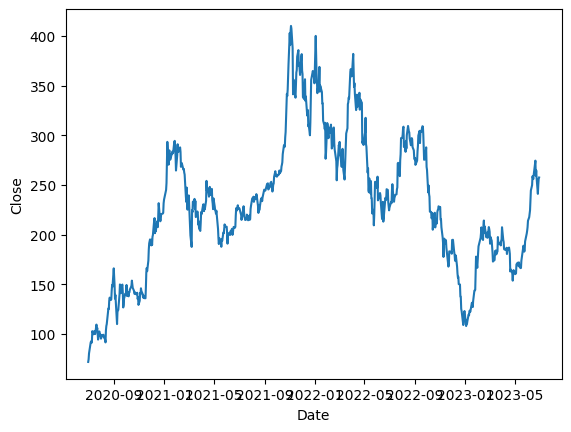

In [90]:
sns.lineplot(x=df['Date'],y=df['Close'])
plt.show()

In [91]:
print("Start date is : ", df['Date'].min())
print("Start date is : ", df['Date'].max())

Start date is :  2020-06-30 00:00:00
Start date is :  2023-06-29 00:00:00


**Train Test Split**

In [92]:
train , test = df.loc[df['Date'] < '2023-01-01'] , df.loc[df['Date'] >= '2023-01-01']

In [93]:
train.sample(10)

,Date,Close
404,2022-02-04,307.773346
489,2022-06-08,241.866669
435,2022-03-22,331.326660
113,2020-12-09,201.493332
569,2022-10-03,242.399994
231,2021-06-01,207.966660
55,2020-09-17,141.143326
387,2022-01-11,354.799988
341,2021-11-04,409.970001
72,2020-10-12,147.433334


In [94]:
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

In [95]:
train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

<ipython-input-95-c7bfe784ac5d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['Close'] = scaler.transform(train[['Close']])
<ipython-input-95-c7bfe784ac5d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Close'] = scaler.transform(test[['Close']])


In [96]:
train.sample(5)

,Date,Close
193,2021-04-07,-0.195170
270,2021-07-27,-0.318167
365,2021-12-09,1.367904
45,2020-09-02,-1.245266
456,2022-04-21,1.391292


In [97]:
seq_size = 30

def to_sequences(x,y, seq_size=1):
  x_value = []
  y_value = []

  for i in range(len(x)-seq_size):
    x_value.append(x.iloc[i:(i+seq_size)].values)
    y_value.append(y.iloc[i:(i+seq_size)])

  return np.array(x_value), np.array(y_value)


In [98]:
trainX , trainY = to_sequences(train[['Close']], train[['Close']], seq_size)
testX , testY = to_sequences(test[['Close']], test[['Close']], seq_size)

In [99]:
trainX[0]

array([[-2.33203131],
       [-2.29462991],
       [-2.21100731],
       [-2.05798255],
       [-2.04081283],
       [-2.0633363 ],
       [-2.03666124],
       [-1.89542426],
       [-1.94012381],
       [-1.92158273],
       [-1.89414696],
       [-1.9367613 ],
       [-1.93657341],
       [-1.80304778],
       [-1.87315434],
       [-1.85064022],
       [-1.92508627],
       [-2.01532122],
       [-1.90016759],
       [-1.9594444 ],
       [-1.93819834],
       [-1.94911257],
       [-2.00239692],
       [-1.95145134],
       [-1.94957284],
       [-1.95143253],
       [-1.94714947],
       [-1.9817801 ],
       [-2.01384656],
       [-2.05534324]])

In [100]:
trainX.shape

(602, 30, 1)

In [101]:
model = Sequential()
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(rate=0.2))

model.add(RepeatVector(trainX.shape[1]))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(trainX.shape[2])))


model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 repeat_vector_4 (RepeatVect  (None, 30, 128)          0         
 or)                                                             
                                                                 
 lstm_9 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_9 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 1)            129       
 tributed)                                            

In [102]:
history = model.fit(trainX,trainY, epochs=30, batch_size=32, validation_split=0.1)

Epoch 1/30
17/17 [==============================] - 8s 230ms/step - loss: 0.3960 - val_loss: 0.3972
Epoch 2/30
17/17 [==============================] - 2s 103ms/step - loss: 0.2849 - val_loss: 0.3381
Epoch 3/30
17/17 [==============================] - 2s 99ms/step - loss: 0.2583 - val_loss: 0.2882
Epoch 4/30
17/17 [==============================] - 2s 98ms/step - loss: 0.2464 - val_loss: 0.2787
Epoch 5/30
17/17 [==============================] - 2s 104ms/step - loss: 0.2471 - val_loss: 0.2503
Epoch 6/30
17/17 [==============================] - 2s 99ms/step - loss: 0.2263 - val_loss: 0.2336
Epoch 7/30
17/17 [==============================] - 3s 168ms/step - loss: 0.2105 - val_loss: 0.2220
Epoch 8/30
17/17 [==============================] - 2s 113ms/step - loss: 0.1975 - val_loss: 0.1872
Epoch 9/30
17/17 [==============================] - 2s 99ms/step - loss: 0.1872 - val_loss: 0.1708
Epoch 10/30
17/17 [==============================] - 2s 97ms/step - loss: 0.1757 - val_loss: 0.1630
Epoc

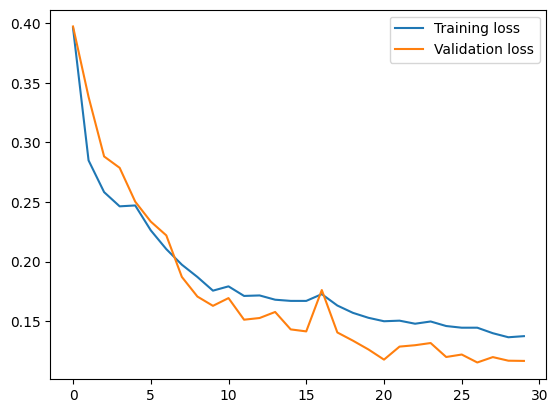

In [103]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

19/19 [==============================] - 1s 30ms/step


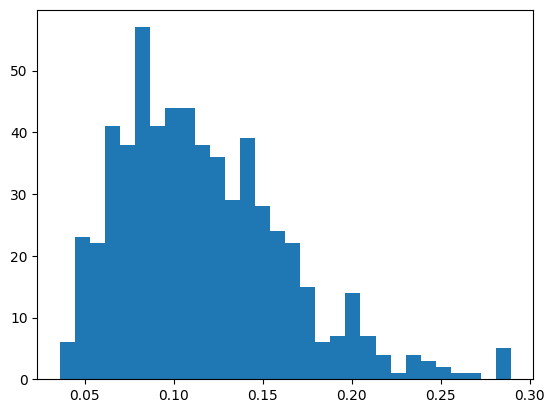

In [104]:
trainPredict = model.predict(trainX)
trainMAE = np.mean(np.abs(trainPredict-trainX), axis=1)
plt.hist(trainMAE, bins=30)
plt.show()

3/3 [==============================] - 0s 27ms/step


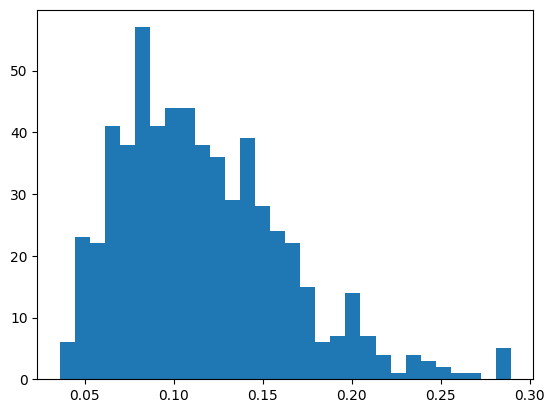

In [105]:
testPredict = model.predict(testX)
testMAE = np.mean(np.abs(testPredict-testX),axis=1)
plt.hist(trainMAE, bins=30)
plt.show()

In [112]:
max_trainMAE = 0.12  # threshold value
anomaly_df = pd.DataFrame(test[seq_size:])
anomaly_df['testMAE'] = testMAE
anomaly_df['max_trainMAE'] = max_trainMAE
anomaly_df['anomaly'] = anomaly_df['testMAE'] > anomaly_df['max_trainMAE']
anomaly_df['Close'] = test[seq_size:]['Close']

<Axes: xlabel='Date', ylabel='testMAE'>

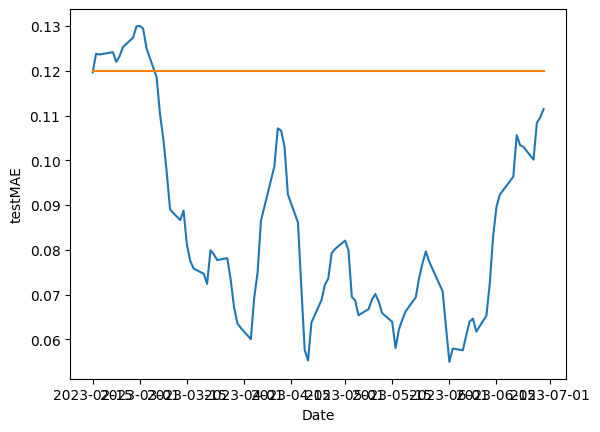

In [113]:
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['testMAE'])
sns.lineplot(x=anomaly_df['Date'], y=anomaly_df['max_trainMAE'])

In [116]:
anomalies = anomaly_df.loc[anomaly_df['anomaly'] == True]
print(anomalies)

          Date     Close   testMAE  max_trainMAE  anomaly
663 2023-02-16 -0.499726  0.123787          0.12     True
664 2023-02-17 -0.411389  0.123630          0.12     True
665 2023-02-21 -0.565522  0.124153          0.12     True
666 2023-02-22 -0.516351  0.121974          0.12     True
667 2023-02-23 -0.499304  0.123267          0.12     True
668 2023-02-24 -0.572425  0.125287          0.12     True
669 2023-02-27 -0.420969  0.127377          0.12     True
670 2023-02-28 -0.448020  0.129901          0.12     True
671 2023-03-01 -0.489441  0.130009          0.12     True
672 2023-03-02 -0.656677  0.129420          0.12     True
673 2023-03-03 -0.559604  0.124976          0.12     True


In [118]:
close_values = scaler.inverse_transform(anomaly_df['Close'].values.reshape(-1, 1))
anomaly_close = scaler.inverse_transform(anomalies['Close'].values.reshape(-1, 1))

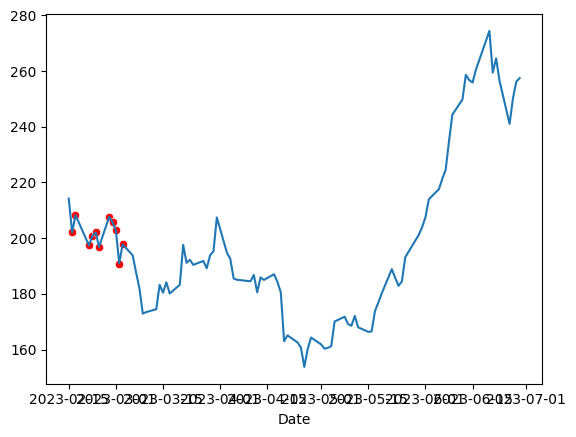

In [119]:
sns.lineplot(x=anomaly_df['Date'], y=close_values.flatten())
sns.scatterplot(x=anomalies['Date'], y=anomaly_close.flatten(), color='r')
plt.show()